# Timeseries via API

In this notebook we use the backend API to retrieve a time series and then plot it.

In [2]:
%matplotlib widget

import httpx
import matplotlib.pyplot as plt
import pandas as pd

coverage_identifier = "tas_absolute-rcp26-DJF"
point_coords = "POINT(11.5469 44.9524)"
date_range = "../.."
api_url = f"http://webapp:5001/api/v2/coverages/time-series/{coverage_identifier}"

In [8]:
raw_response = httpx.get(
    api_url,
    params={
        "coords": point_coords,
        "datetime": date_range,
        "include_coverage_data": True,
        "include_observation_data": True,
        "coverage_data_smoothing": [
            "NO_SMOOTHING",
            "MOVING_AVERAGE_11_YEARS",
            "LOESS_SMOOTHING",
        ],
        "observation_data_smoothing": [
            "NO_SMOOTHING",
            "MOVING_AVERAGE_5_YEARS",
        ],
        "include_coverage_uncertainty": False,
        "include_coverage_related_data": False,
    }
)
raw_response.raise_for_status()

raw_series = raw_response.json()["series"]

series = {s["name"]: s for s in raw_series}

raw_coverage_df = pd.DataFrame.from_records(series[f"{coverage_identifier}__NO_SMOOTHING"]["values"])
raw_coverage_df["datetime"] = pd.to_datetime(raw_coverage_df["datetime"])
raw_coverage_df.set_index("datetime", inplace=True)

smoothed_ma11_coverage_df = pd.DataFrame.from_records(series[f"{coverage_identifier}__MOVING_AVERAGE_11_YEARS"]["values"])
smoothed_ma11_coverage_df["datetime"] = pd.to_datetime(smoothed_ma11_coverage_df["datetime"])
smoothed_ma11_coverage_df.set_index("datetime", inplace=True)

smoothed_loess_coverage_df = pd.DataFrame.from_records(series[f"{coverage_identifier}__LOESS_SMOOTHING"]["values"])
smoothed_loess_coverage_df["datetime"] = pd.to_datetime(smoothed_loess_coverage_df["datetime"])
smoothed_loess_coverage_df.set_index("datetime", inplace=True)

raw_station_df = pd.DataFrame.from_records(series["TDd__NO_SMOOTHING"]["values"])
raw_station_df["datetime"] = pd.to_datetime(raw_station_df["datetime"])
raw_station_df.set_index("datetime", inplace=True)

smoothed_ma5_station_df = pd.DataFrame.from_records(series["TDd__MOVING_AVERAGE_5_YEARS"]["values"])
smoothed_ma5_station_df["datetime"] = pd.to_datetime(smoothed_ma5_station_df["datetime"])
smoothed_ma5_station_df.set_index("datetime", inplace=True)


### Plotting

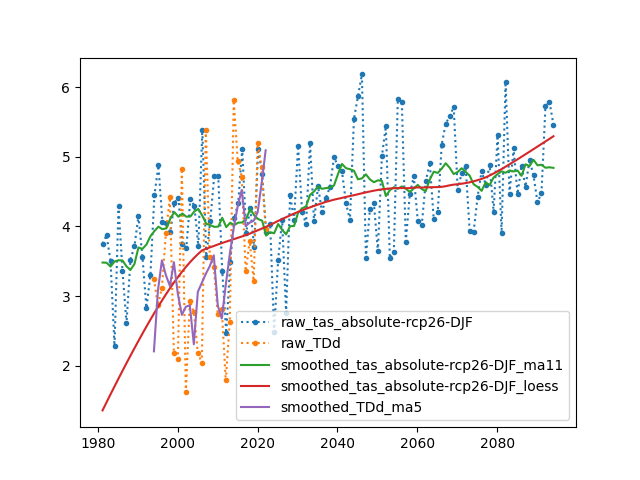

In [10]:
fig, ax = plt.subplots()
raw_tas_line, = ax.plot(raw_coverage_df, label=f"raw_{coverage_identifier}")
raw_station_line, = ax.plot(raw_station_df, label="raw_TDd")
raw_tas_line.set_linestyle(":")
raw_tas_line.set_marker(".")
raw_station_line.set_linestyle(":")
raw_station_line.set_marker(".")

smoothed_ma11_tas_line, = ax.plot(smoothed_ma11_coverage_df, label=f"smoothed_{coverage_identifier}_ma11")
smoothed_loess_tas_line, = ax.plot(smoothed_loess_coverage_df, label=f"smoothed_{coverage_identifier}_loess")
smoothed_ma5_station_line, = ax.plot(smoothed_ma5_station_df, label="smoothed_TDd_ma5")
ax.legend()

In [23]:
ax.clear()